In [11]:
''' Section: 基本回归：预测消耗收益
汽车MPG数据集：
    获取数据
    数据清理
    分割训练数据集和测试数据集
    数据检查
    从标签中分离特征
    数据规范化
模型
    构建模型
    检查模型
    训练模型
    做预测


在回归问题中，我们的目标是预测出如价格或概率这样连续值的输出，相对于分类问题

使用汽车MPG数据集，构建一个用于预测汽车燃油效率的模型

包含颗粒数、排量、马力以及重量

'''

# TODO: 使用seaborn绘制矩阵图

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
# #
# from tensorflow import keras
# from keras import layers
print(tf.__version__)


2.13.0


In [12]:
# Section: 获取数据集
# dataset_path = keras.utils.get_file("auto-mpg.data",
dataset_path = "E:/LocalRepository/DataSet/Fashion_MNIST/auto_mpg/auto-mpg.data"
dataset_path

'E:/LocalRepository/DataSet/Fashion_MNIST/auto_mpg/auto-mpg.data'

In [13]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [14]:
# SECTION: 数据清理：数据集中包含一些未知道
# 此方法用于检测array-like对象的缺失值
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [15]:
# 为了保证最初示例的简单性，删除这些行
# pandas的dropna()方法-丢弃含空值的行、列
dataset = dataset.dropna()

# "Origin"列实际上代表分类，而不仅仅是一个数字，所以把它装换为独热码（one-hot）
# pop方法可以将所选列从原数据块中弹出，原数据块不再保留该列。
origin = dataset.pop('Origin')


# 根据origin列来写入新列
dataset['USA'] = (origin == 1)* 1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


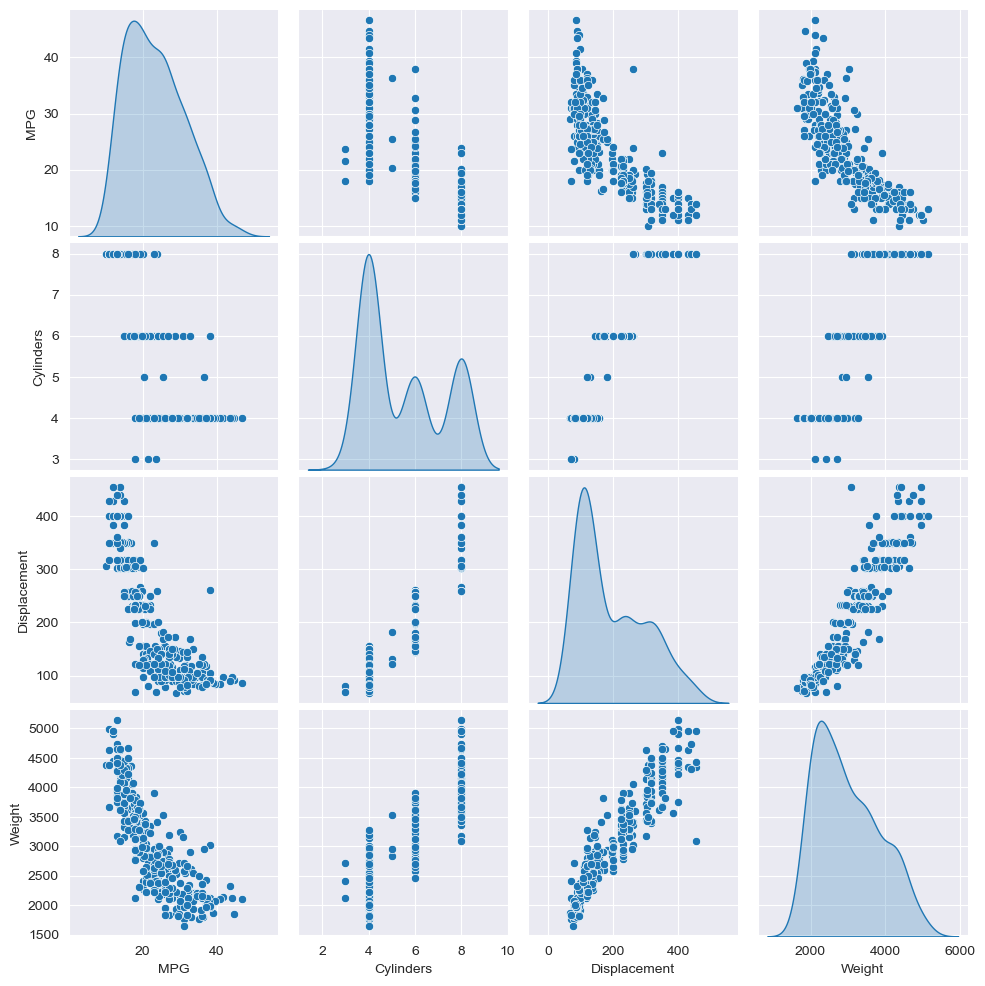

In [16]:
# SECTION: 分割训练数据集和测试数据集
'''
现在需要将数据集拆分为一个训练数据集和一个测试数据集

我们最后将使用测试数据集对模型进行评估
'''
#  #frac取样比例， random_state如果值为int, 则为随机数生成器或numpy RandomState对象设置种子
train_dataset = dataset.sample(frac=0.8, random_state=0)
#  #取train_dataset的数据下标，并drop，形成test_datase
test_dataset = dataset.drop(train_dataset.index)

# 数据检查
'''
快速查看集中训练几对列的联合分配
'''
# pairplot主要展现的是变量两两之间的关系
# kind：用于控制非对角线上的图的类型，可选"scatter"与"reg"
# diag_kind：控制对角线上的图的类型，可选"hist"与"kde"
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [17]:
'''
   count：数量统计，此列共有多少有效值
   unipue：不同的值有多少个
   std：标准差
   min：最小值
   25%：四分之一分位数
   50%：二分之一分位数
   75%：四分之三分位数
   max：最大值
   mean：均值
'''
# 而describe()函数就是返回数据结构的统计变量
train_stats = train_dataset.describe()
# # 把这列数据去掉
train_stats.pop("MPG")
# 矩阵转置 就，把行和列的标签互换
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [18]:
# 从标签中分离特征
'''
将特征值从目标值或者"标签"中训练分离
这个标签是你使用模型进行预测的值
'''
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [20]:
# SECTION: 数据规范化
'''
使用不同的刻度和范围对特征归一化是好的做法，尽管模型可能在没有特征归一化的情况下收敛
但它会使得模型训练更加复杂，并会导致生成的模型依赖输入所使用的单位选择

我们将使用这个已经归一化的数据来训练模型

用于归一化输入的数据统计(均值和标准差)需要反馈给模型从而影响任何其他数据，以及我们之前所需要获得的独热码
这些数据包含测试数据集以及生产环境中所使用的实时数据+

'''
def norm(x):
    # mean:均值。 std:标准差
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_train_data)


     Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
146  -0.869348     -1.009459   -0.784052 -1.025303     -0.379759   -0.516397   
282  -0.869348     -0.530218   -0.442811 -0.118796      0.624102    0.843910   
69    1.483887      1.482595    1.447140  1.736877     -0.738281   -1.060519   
378  -0.869348     -0.865687   -1.099044 -1.025303     -0.308055    1.660094   
331  -0.869348     -0.942365   -0.994047 -1.001603      0.875068    1.115971   
..         ...           ...         ...       ...           ...         ...   
281   0.307270      0.044872   -0.521559 -0.000298      0.946772    0.843910   
229   1.483887      1.961837    1.972127  1.457223     -1.598734    0.299787   
150  -0.869348     -0.836932   -0.311564 -0.710099     -0.021237   -0.516397   
145  -0.869348     -1.076553   -1.151543 -1.169870      1.233589   -0.516397   
182  -0.869348     -0.846517   -0.495310 -0.623596     -0.021237    0.027726   

          USA    Europe     Japan  
146

In [11]:
# SECTION: 模型
# SECTION: 构建模型
'''
我们将使用一个顺序模型，其中包含两个紧密相连的隐藏层
以及返回单个、连续有价值的输出层，模型的构建步骤包含一个名为“build_model”的函数中，
隐藏稍后我们将创建第二个模型，两个密集连接的层
'''
def build_model():
    # 容器
    model = tf.keras.Sequential([
        # 全连接一般会把卷积输出的二维特征图转化成一维的一个向量
        # 引入激活函数的目的是为了进行非线性变化，使得模型更加适配非线线函数
        tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), # 输出空间维度: 64维
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    # 评估指标：MAE:平均绝对误差，MSE：均方误差
    return model
model = build_model()

In [12]:
# SECTION: 检查模型
'''
使用.summary方法来打印该模型的简单描述
'''
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4865 (19.00 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# 现在尝试下这个模型。从数据训练中皮两获取10条示例这些示例调用model.predict
examp_batch = normed_train_data[:10]
examp_result = model.predict(examp_batch)
examp_result

1/1 [==============================] - 0s 109ms/step


array([[-0.00129736],
       [-0.08809329],
       [-0.5225214 ],
       [ 0.2164092 ],
       [ 0.0107469 ],
       [-0.11419632],
       [-0.01708072],
       [-0.138321  ],
       [-0.15950567],
       [-0.29661733]], dtype=float32)

In [14]:
# SECTION:训练模型
'''
对模型进行1000个周期的训练，并在history对象中记录训练和验证的准确性
'''

# 通过为每个完成的时期打印一个点来显示训练进度

class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(' ')
        print('.', end='')

EPOCHS= 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
................................................................................

In [15]:
# 使用history对象中存储的统计信息可视化模型的训练细节

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
# 默认显示为数据集的最后5行
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.288208,0.959419,2.288208,10.249859,2.492260,10.249859,995
996,2.287964,0.948004,2.287964,9.643941,2.327738,9.643941,996
997,2.315125,0.955293,2.315125,10.210118,2.471693,10.210118,997
998,2.230917,0.952488,2.230917,10.292105,2.459891,10.292105,998
999,2.486373,1.003448,2.486373,9.409484,2.374214,9.409484,999


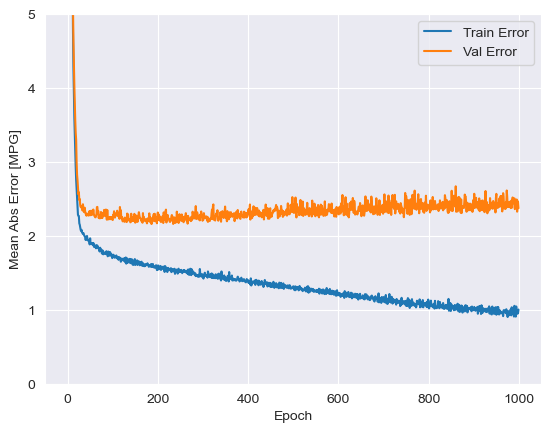

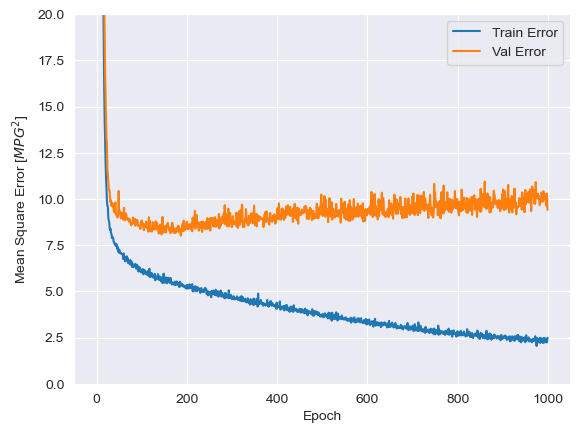

In [16]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

 
...............................................

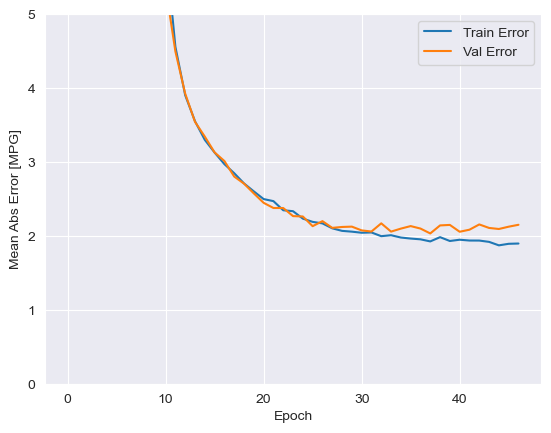

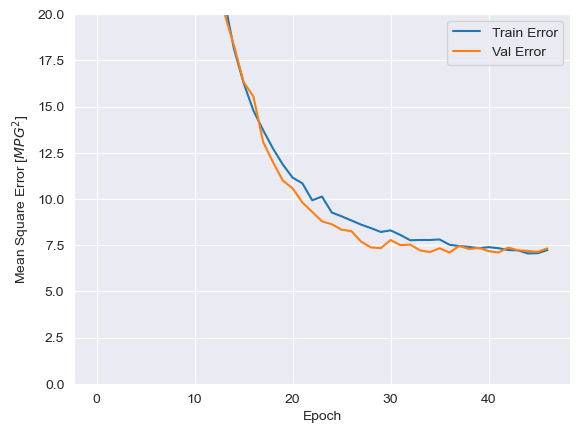

In [17]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 在每个training/epoch/batch结束时，可以通过回调函数Callbacks查看一些内部信息。常用的callback有EarlyStopping，当监视的变量停止改善时，停止训练，防止模型过拟合，
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [18]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7792 - mae: 1.8311 - mse: 5.7792 - 16ms/epoch - 5ms/step
Testing set Mean Abs Error:  1.83 MPG


3/3 [==============================] - 0s 1ms/step


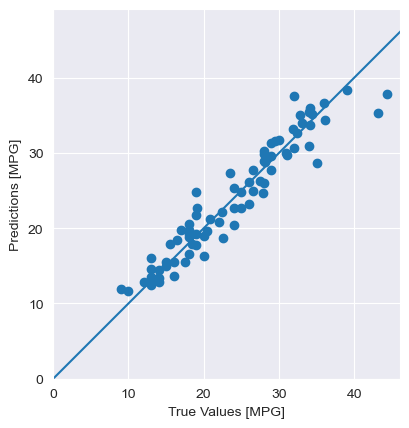

In [19]:
# Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
# Flatten不影响batch的大小
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

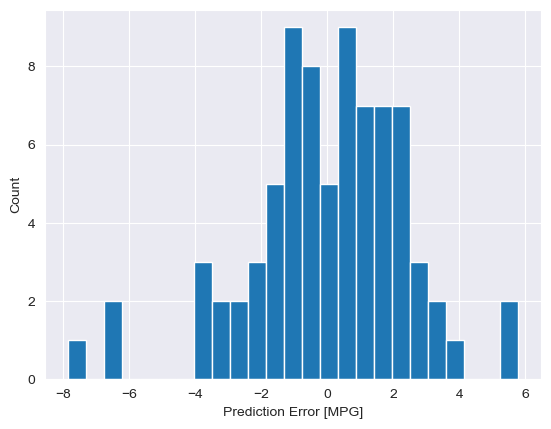

In [20]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")